# Amazon Web Services - Use Case 1

# <a name="0">Sample Note Book: Feature Engineering, Tree-based Models, and Hyperparameter Tuning</a>


## Decision Tree Model 

In this notebook, we build, train, and tune by [__GridSearchCV__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) a [__Decision Tree Classifier__](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to predict the __target_label__ field (plug or no plug) of FIFA 2019 Dataset (Kaggle Data Set). 

1. <a href="#1">Read the dataset</a>
2. <a href="#2">Exploratory Data Analysis</a>
3. <a href="#3">Select features to build the model</a>
4. <a href="#4">Training and test datasets</a>
5. <a href="#5">Data processing with Pipeline and ColumnTransformer</a>
6. <a href="#6">Train and tune a classifier</a>
7. <a href="#7">Test the classifier</a>
8. <a href="#8">Improvement ideas</a>



In [1]:
#Upgrade dependencies
!pip install --upgrade pip
!pip install --upgrade scikit-learn

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages (20.2.1)
Requirement already up-to-date: scikit-learn in /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages (0.23.2)


## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's read the dataset into a dataframe, using Pandas.

In [2]:
import numpy as np                                
import matplotlib.pyplot as plt   
from IPython.display import Image                 
from IPython.display import display               
from sklearn.datasets import dump_svmlight_file   
from time import gmtime, strftime                 
import sys                                        
import math                                       
import json
import boto3
import sagemaker

bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/fifa19'
role = sagemaker.get_execution_role()

print('Bucket:\n{}'.format(bucket))


Bucket:
sagemaker-us-east-2-866120629632


In [3]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
  
df = pd.read_csv('football-players-data.csv')

print('The shape of the training dataset is:', df.shape)

The shape of the training dataset is: (18207, 89)


## 2. <a name="2">Exploratory Data Analysis</a>
(<a href="#0">Go to top</a>)

We look at number of rows, columns and some simple statistics of the dataset.

In [4]:
# Print the first five rows
# NaN means missing data
df.head(10)

Unnamed: 0      ID               Name  Age  \
0           0  158023           L. Messi   31   
1           1   20801  Cristiano Ronaldo   33   
2           2  190871          Neymar Jr   26   
3           3  193080             De Gea   27   
4           4  192985       K. De Bruyne   27   
5           5  183277          E. Hazard   27   
6           6  177003          L. Modrić   32   
7           7  176580          L. Suárez   31   
8           8  155862       Sergio Ramos   32   
9           9  200389           J. Oblak   25   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   
5  https://cdn.sofifa.org/players/4/19/183277.png     Belgium   
6  https://cdn.sofifa.org/players/4/19/177003.png     Croatia   
7  https://cdn.sofifa.org/players/4/19/176580.png     Uruguay   
8  https://cdn.sofifa.org/players/4/19/155862.png       Spain   
9  https://cdn.sofifa.org/players/4/19/200389.png    Slovenia   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   
5   https://cdn.sofifa.org/flags/7.png       91         91   
6  https://cdn.sofifa.org/flags/10.png       91         91   
7  https://cdn.sofifa.org/flags/60.png       91         91   
8  https://cdn.sofifa.org/flags/45.png       91         91   
9  https://cdn.sofifa.org/flags/44.png       90         93   

                  Club  ... Composure Marking StandingTackle  SlidingTackle  \
0         FC Barcelona  ...      96.0    33.0           28.0           26.0   
1             Juventus  ...      95.0    28.0           31.0           23.0   
2  Paris Saint-Germain  ...      94.0    27.0           24.0           33.0   
3    Manchester United  ...      68.0    15.0           21.0           13.0   
4      Manchester City  ...      88.0    68.0           58.0           51.0   
5              Chelsea  ...      91.0    34.0           27.0           22.0   
6          Real Madrid  ...      84.0    60.0           76.0           73.0   
7         FC Barcelona  ...      85.0    62.0           45.0           38.0   
8          Real Madrid  ...      82.0    87.0           92.0           91.0   
9      Atlético Madrid  ...      70.0    27.0           12.0           18.0   

  GKDiving  GKHandling  GKKicking  GKPositioning GKReflexes Release Clause  
0      6.0        11.0       15.0           14.0        8.0        €226.5M  
1      7.0        11.0       15.0           14.0       11.0        €127.1M  
2      9.0         9.0       15.0           15.0       11.0        €228.1M  
3     90.0        85.0       87.0           88.0       94.0        €138.6M  
4     15.0        13.0        5.0           10.0       13.0        €196.4M  
5     11.0        12.0        6.0            8.0        8.0        €172.1M  
6     13.0         9.0        7.0           14.0        9.0        €137.4M  
7     27.0        25.0       31.0           33.0       37.0          €164M  
8     11.0         8.0        9.0            7.0       11.0        €104.6M  
9     86.0        92.0       78.0           88.0       89.0        €144.5M  

[10 rows x 89 columns]

In [5]:
print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (18207, 89)


In [6]:
#for i in range(0,len(df.columns)):
#    print(df.columns[i:i+10])

In [7]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

In [8]:
# This will print basic statistics for numerical columns
df.describe()

Unnamed: 0             ID           Age       Overall     Potential  \
count  18207.000000   18207.000000  18207.000000  18207.000000  18207.000000   
mean    9103.000000  214298.338606     25.122206     66.238699     71.307299   
std     5256.052511   29965.244204      4.669943      6.908930      6.136496   
min        0.000000      16.000000     16.000000     46.000000     48.000000   
25%     4551.500000  200315.500000     21.000000     62.000000     67.000000   
50%     9103.000000  221759.000000     25.000000     66.000000     71.000000   
75%    13654.500000  236529.500000     28.000000     71.000000     75.000000   
max    18206.000000  246620.000000     45.000000     94.000000     95.000000   

            Special  International Reputation     Weak Foot   Skill Moves  \
count  18207.000000              18159.000000  18159.000000  18159.000000   
mean    1597.809908                  1.113222      2.947299      2.361308   
std      272.586016                  0.394031      0.660456      0.756164   
min      731.000000                  1.000000      1.000000      1.000000   
25%     1457.000000                  1.000000      3.000000      2.000000   
50%     1635.000000                  1.000000      3.000000      2.000000   
75%     1787.000000                  1.000000      3.000000      3.000000   
max     2346.000000                  5.000000      5.000000      5.000000   

       Jersey Number  ...     Penalties     Composure       Marking  \
count   18147.000000  ...  18159.000000  18159.000000  18159.000000   
mean       19.546096  ...     48.548598     58.648274     47.281623   
std        15.947765  ...     15.704053     11.436133     19.904397   
min         1.000000  ...      5.000000      3.000000      3.000000   
25%         8.000000  ...     39.000000     51.000000     30.000000   
50%        17.000000  ...     49.000000     60.000000     53.000000   
75%        26.000000  ...     60.000000     67.000000     64.000000   
max        99.000000  ...     92.000000     96.000000     94.000000   

       StandingTackle  SlidingTackle      GKDiving    GKHandling  \
count    18159.000000   18159.000000  18159.000000  18159.000000   
mean        47.697836      45.661435     16.616223     16.391596   
std         21.664004      21.289135     17.695349     16.906900   
min          2.000000       3.000000      1.000000      1.000000   
25%         27.000000      24.000000      8.000000      8.000000   
50%         55.000000      52.000000     11.000000     11.000000   
75%         66.000000      64.000000     14.000000     14.000000   
max         93.000000      91.000000     90.000000     92.000000   

          GKKicking  GKPositioning    GKReflexes  
count  18159.000000   18159.000000  18159.000000  
mean      16.232061      16.388898     16.710887  
std       16.502864      17.034669     17.955119  
min        1.000000       1.000000      1.000000  
25%        8.000000       8.000000      8.000000  
50%       11.000000      11.000000     11.000000  
75%       14.000000      14.000000     14.000000  
max       91.000000      90.000000     94.000000  

[8 rows x 44 columns]

#### Target distribution

Let's check our target distribution.

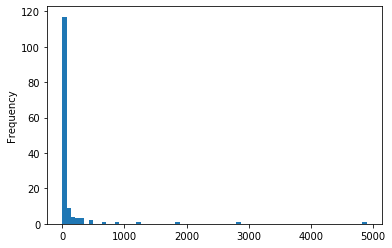

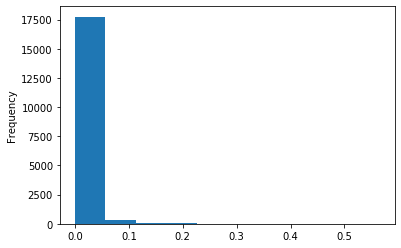

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

df['Wage'].value_counts().plot.hist(bins=70)
plt.show()

df['Wage'].plot.hist(bins=10)
plt.show()

We can see from the target plot above that we are dealing with an imbalanced dataset. This means one result type is dominating the other one(s). But this is a regression model, and no issue for this data set

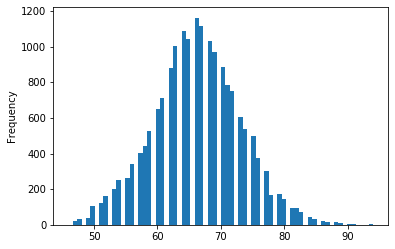

In [10]:
df['Overall'].plot.hist(bins=70)
plt.show()

In [11]:
df['Wage'].head(2)

0    €565K
1    €405K
Name: Wage, dtype: object

In [12]:
#currency converter
def euroStr2Int(amount):
    new_amount = []
    for s in amount:
        list(s)
        abbr = s[-1]
        if abbr is 'M':
            s = s[1:-1]
            s = float(''.join(s))
            s *= 1000000
        elif abbr is 'K':
            s = s[1:-1]
            s = float(''.join(s))
            s *= 1000
        else:
            s = 0
        new_amount.append(s)
    return new_amount

# convert 
def heightStr2Int(height):
    new_height = []
    for h in height:
        if type(h) is str:
            list(h)
            h = (float(h[0])*12) + float(h[2:])
        new_height.append(h)
    return new_height

def weightStr2Int(weight):
    new_weight = []
    for w in weight:
        if type(w) is str:
            w = float(w[0:-3])
        new_weight.append(w)
    return new_weight

In [13]:
#Convert Value and Wage to float
df['Value'] = euroStr2Int(list(df['Value']))
df['Wage'] = euroStr2Int(list(df['Wage']))

#Convert height
df['Height'] = heightStr2Int(list(df['Height']))
mean_height = df['Height'].mean()
df.Height.loc[df['Height'].isnull()] = mean_height


#Convert Weight
df['Weight'] = weightStr2Int(list(df['Weight']))
mean_weight = df['Weight'].mean()
df.Weight.loc[df['Weight'].isnull()] = mean_weight

In [14]:
df['Wage'].head(2)

0    565000.0
1    405000.0
Name: Wage, dtype: float64

In [15]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  float64
 12  Wage                      18207 non-null  float64
 13  Special                   18207 non-null  int64  
 14  Prefer

In [16]:
# Number of unique elements in dataset
df.nunique()

Unnamed: 0        18207
ID                18207
Name              17194
Age                  29
Photo             18207
                  ...  
GKHandling           70
GKKicking            79
GKPositioning        79
GKReflexes           76
Release Clause     1244
Length: 89, dtype: int64

In [17]:
# What columns are in dataset?
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

Text(0.5, 1, 'dataset correlation')

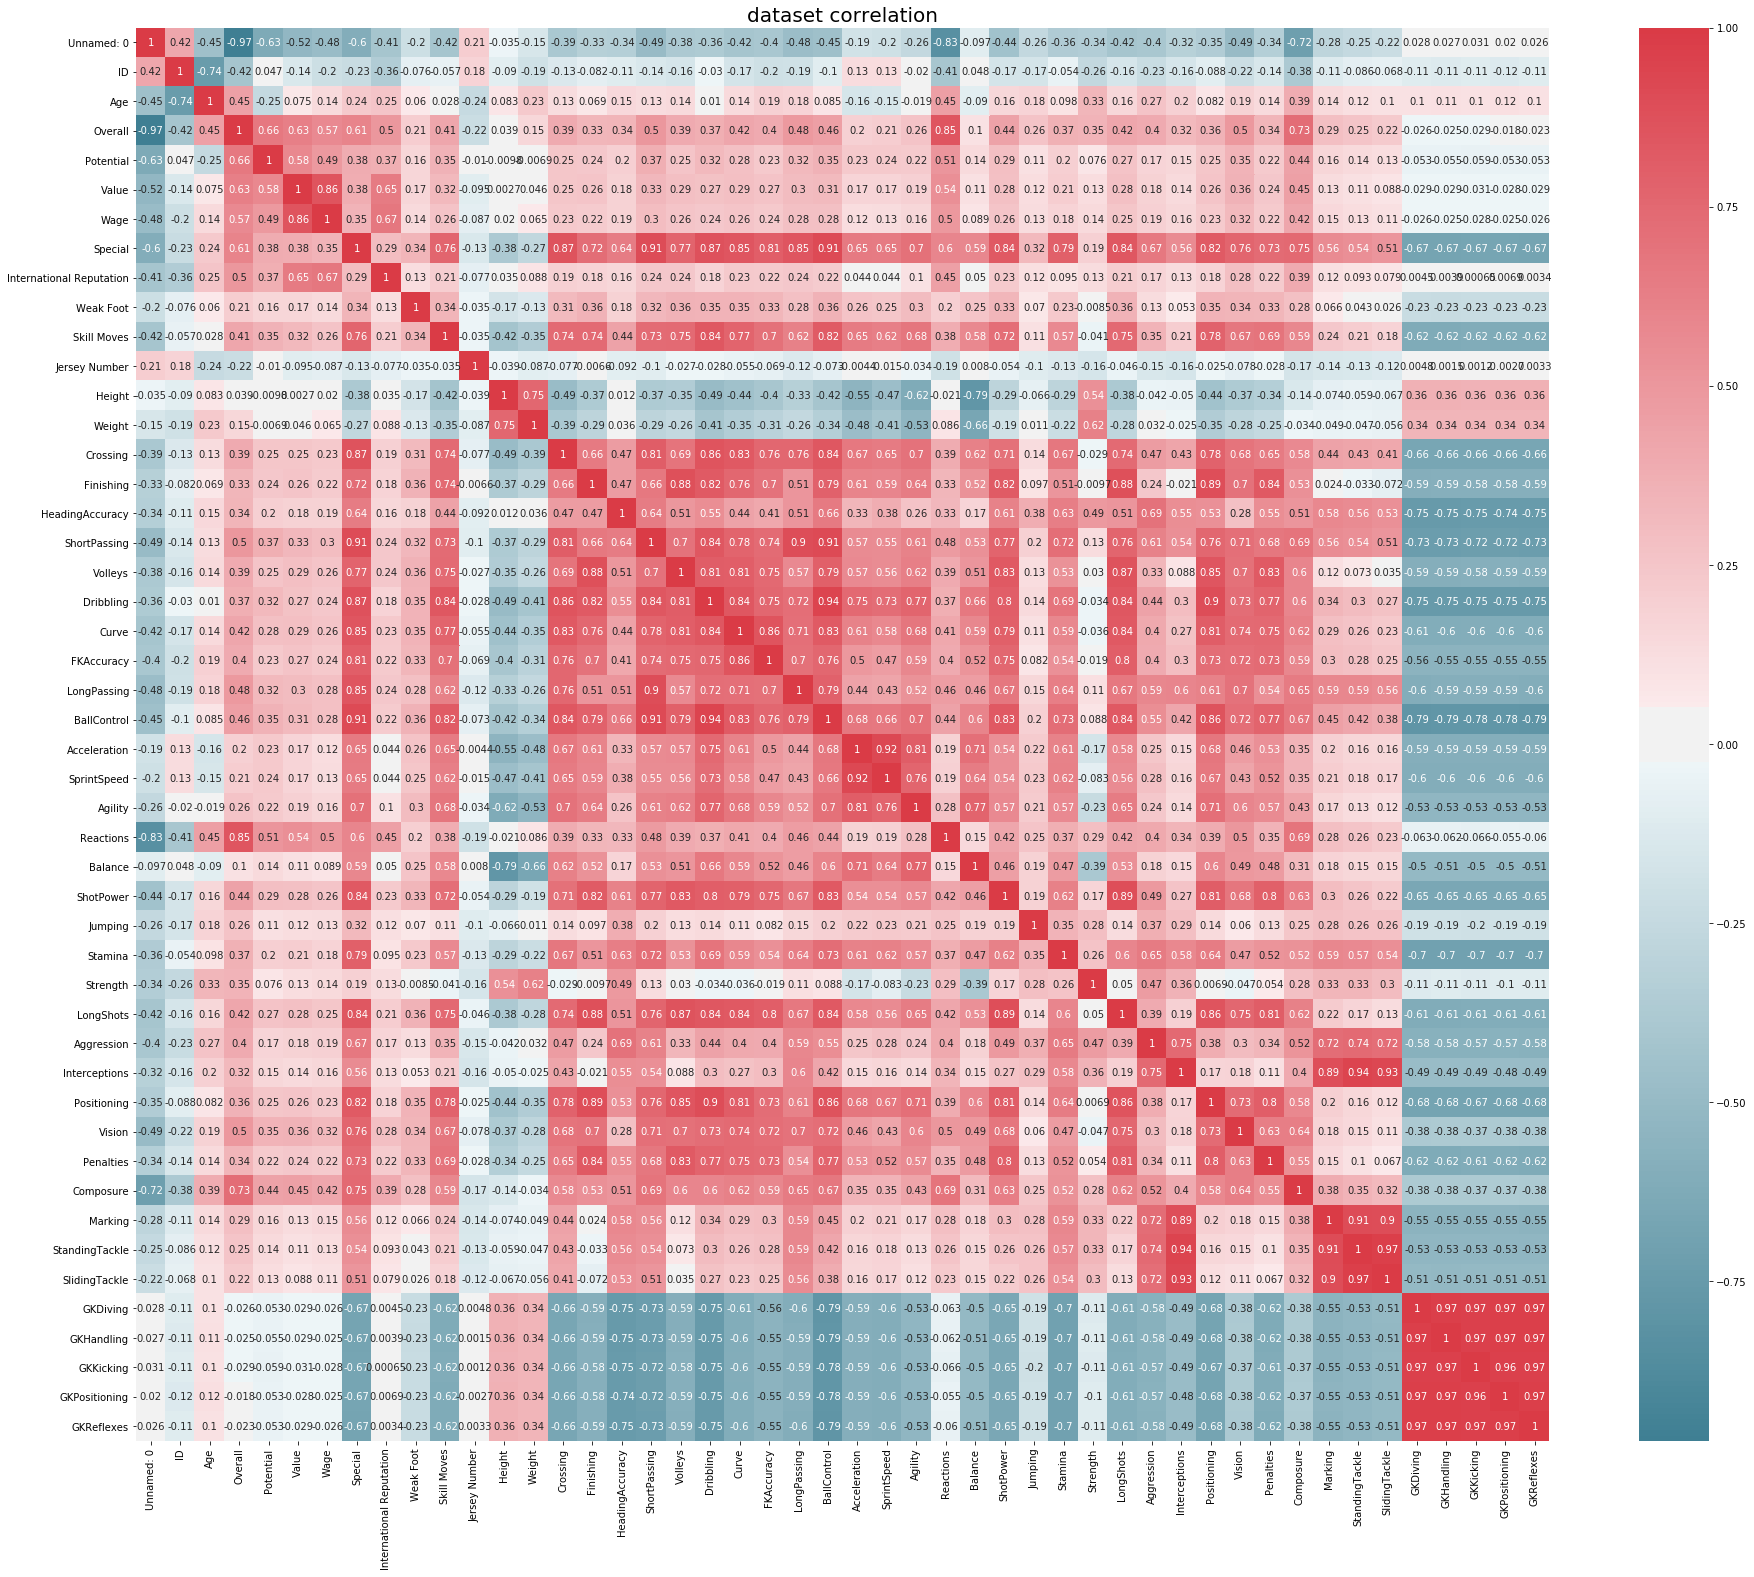

In [18]:
# Display correlation after removing correlated features
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(32, 26))
corr = df.corr()
mp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot = True)
mp.set_title(label='dataset correlation', fontsize=20)

In [19]:
numeric_features = ['Age', 'Overall', 'Potential', 'Special', 'Acceleration', 'Aggression', 'Agility', 
                   'Balance', 'BallControl', 'Composure', 'Crossing', 'Curve', 'Dribbling', 'FKAccuracy', 
                   'Finishing', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 
                   'HeadingAccuracy', 'Interceptions', 'Jersey Number', 'Jumping', 
                   'LongPassing', 'LongShots', 'Marking', 'Penalties', 'Positioning', 'Reactions', 'ShortPassing', 
                   'ShotPower', 'SlidingTackle', 'SprintSpeed', 'Stamina', 'StandingTackle', 
                   'Strength', 'Value', 'Vision', 'Volleys']

date_features = ['Joined']

text_categorical_features =  ['Nationality', 'Body Type', 'Club', 'Position', 'Preferred Foot', 'Work Rate']

numeric_categorical_features =  ['International Reputation', 'Skill Moves', 'Weak Foot']

non_useful_features = ['Unnamed', 'ID', 'Name', 'Photo', 'Flag', 'Club Logo']

label_feature = ['Wage']

In [20]:
df[numeric_features].head()

Age  Overall  Potential  Special  Acceleration  Aggression  Agility  \
0   31       94         94     2202          91.0        48.0     91.0   
1   33       94         94     2228          89.0        63.0     87.0   
2   26       92         93     2143          94.0        56.0     96.0   
3   27       91         93     1471          57.0        38.0     60.0   
4   27       91         92     2281          78.0        76.0     79.0   

   Balance  BallControl  Composure  ...  ShortPassing  ShotPower  \
0     95.0         96.0       96.0  ...          90.0       85.0   
1     70.0         94.0       95.0  ...          81.0       95.0   
2     84.0         95.0       94.0  ...          84.0       80.0   
3     43.0         42.0       68.0  ...          50.0       31.0   
4     77.0         91.0       88.0  ...          92.0       91.0   

   SlidingTackle  SprintSpeed  Stamina  StandingTackle  Strength        Value  \
0           26.0         86.0     72.0            28.0      59.0  110500000.0   
1           23.0         91.0     88.0            31.0      79.0   77000000.0   
2           33.0         90.0     81.0            24.0      49.0  118500000.0   
3           13.0         58.0     43.0            21.0      64.0   72000000.0   
4           51.0         76.0     90.0            58.0      75.0  102000000.0   

   Vision  Volleys  
0    94.0     86.0  
1    82.0     87.0  
2    87.0     84.0  
3    68.0     13.0  
4    94.0     82.0  

[5 rows x 40 columns]

In [21]:
df[text_categorical_features].nunique()

Nationality       164
Body Type          10
Club              651
Position           27
Preferred Foot      2
Work Rate           9
dtype: int64

In [22]:
df[numeric_categorical_features].nunique()

International Reputation    5
Skill Moves                 5
Weak Foot                   5
dtype: int64

In [23]:
#remove duplicates
df.drop_duplicates(inplace=True)

In [24]:
#drop non necessary columns
#dfc.drop(features_drop, axis=1, inplace=True)
#dfc_t.drop(features_drop, axis=1, inplace=True)

## 3. <a name="3">Select features to build the model</a>
(<a href="#0">Go to top</a>)

We build a model using selected features (except __ID, Name, Links__). That is, we build a regressor including __numerical, and categorical__  features. 

In [25]:
all_features = numeric_features + text_categorical_features + numeric_categorical_features + label_feature #+ date_features

In [26]:
label = 'Wage'

In [27]:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [28]:
df[all_features].head(10)

Age  Overall  Potential  Special  Acceleration  Aggression  Agility  \
0   31       94         94     2202          91.0        48.0     91.0   
1   33       94         94     2228          89.0        63.0     87.0   
2   26       92         93     2143          94.0        56.0     96.0   
3   27       91         93     1471          57.0        38.0     60.0   
4   27       91         92     2281          78.0        76.0     79.0   
5   27       91         91     2142          94.0        54.0     95.0   
6   32       91         91     2280          80.0        62.0     93.0   
7   31       91         91     2346          86.0        87.0     82.0   
8   32       91         91     2201          76.0        88.0     78.0   
9   25       90         93     1331          43.0        34.0     67.0   

   Balance  BallControl  Composure  ...  Nationality   Body Type  \
0     95.0         96.0       96.0  ...    Argentina       Messi   
1     70.0         94.0       95.0  ...     Portugal  C. Ronaldo   
2     84.0         95.0       94.0  ...       Brazil      Neymar   
3     43.0         42.0       68.0  ...        Spain        Lean   
4     77.0         91.0       88.0  ...      Belgium      Normal   
5     94.0         94.0       91.0  ...      Belgium      Normal   
6     94.0         93.0       84.0  ...      Croatia        Lean   
7     83.0         90.0       85.0  ...      Uruguay      Normal   
8     66.0         84.0       82.0  ...        Spain      Normal   
9     49.0         16.0       70.0  ...     Slovenia      Normal   

                  Club  Position  Preferred Foot       Work Rate  \
0         FC Barcelona        RF            Left  Medium/ Medium   
1             Juventus        ST           Right       High/ Low   
2  Paris Saint-Germain        LW           Right    High/ Medium   
3    Manchester United        GK           Right  Medium/ Medium   
4      Manchester City       RCM           Right      High/ High   
5              Chelsea        LF           Right    High/ Medium   
6          Real Madrid       RCM           Right      High/ High   
7         FC Barcelona        RS           Right    High/ Medium   
8          Real Madrid       RCB           Right    High/ Medium   
9      Atlético Madrid        GK           Right  Medium/ Medium   

   International Reputation  Skill Moves  Weak Foot      Wage  
0                       5.0          4.0        4.0  565000.0  
1                       5.0          5.0        4.0  405000.0  
2                       5.0          5.0        5.0  290000.0  
3                       4.0          1.0        3.0  260000.0  
4                       4.0          4.0        5.0  355000.0  
5                       4.0          4.0        4.0  340000.0  
6                       4.0          4.0        4.0  420000.0  
7                       5.0          3.0        4.0  455000.0  
8                       4.0          3.0        3.0  380000.0  
9                       3.0          1.0        3.0   94000.0  

[10 rows x 50 columns]

In [29]:
print('Numerical categorial columns:', df[numeric_categorical_features].select_dtypes(include=np.number).columns)
print('Numerical            columns:', df[numeric_features].select_dtypes(include=np.number).columns)
print('Text   Categorical columns:',df[text_categorical_features].select_dtypes(include='object').columns)

Numerical categorial columns: Index(['International Reputation', 'Skill Moves', 'Weak Foot'], dtype='object')
Numerical            columns: Index(['Age', 'Overall', 'Potential', 'Special', 'Acceleration', 'Aggression',
       'Agility', 'Balance', 'BallControl', 'Composure', 'Crossing', 'Curve',
       'Dribbling', 'FKAccuracy', 'Finishing', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'HeadingAccuracy',
       'Interceptions', 'Jersey Number', 'Jumping', 'LongPassing', 'LongShots',
       'Marking', 'Penalties', 'Positioning', 'Reactions', 'ShortPassing',
       'ShotPower', 'SlidingTackle', 'SprintSpeed', 'Stamina',
       'StandingTackle', 'Strength', 'Value', 'Vision', 'Volleys'],
      dtype='object')
Text   Categorical columns: Index(['Nationality', 'Body Type', 'Club', 'Position', 'Preferred Foot',
       'Work Rate'],
      dtype='object')


Text(0.5, 1, 'dataset correlation')

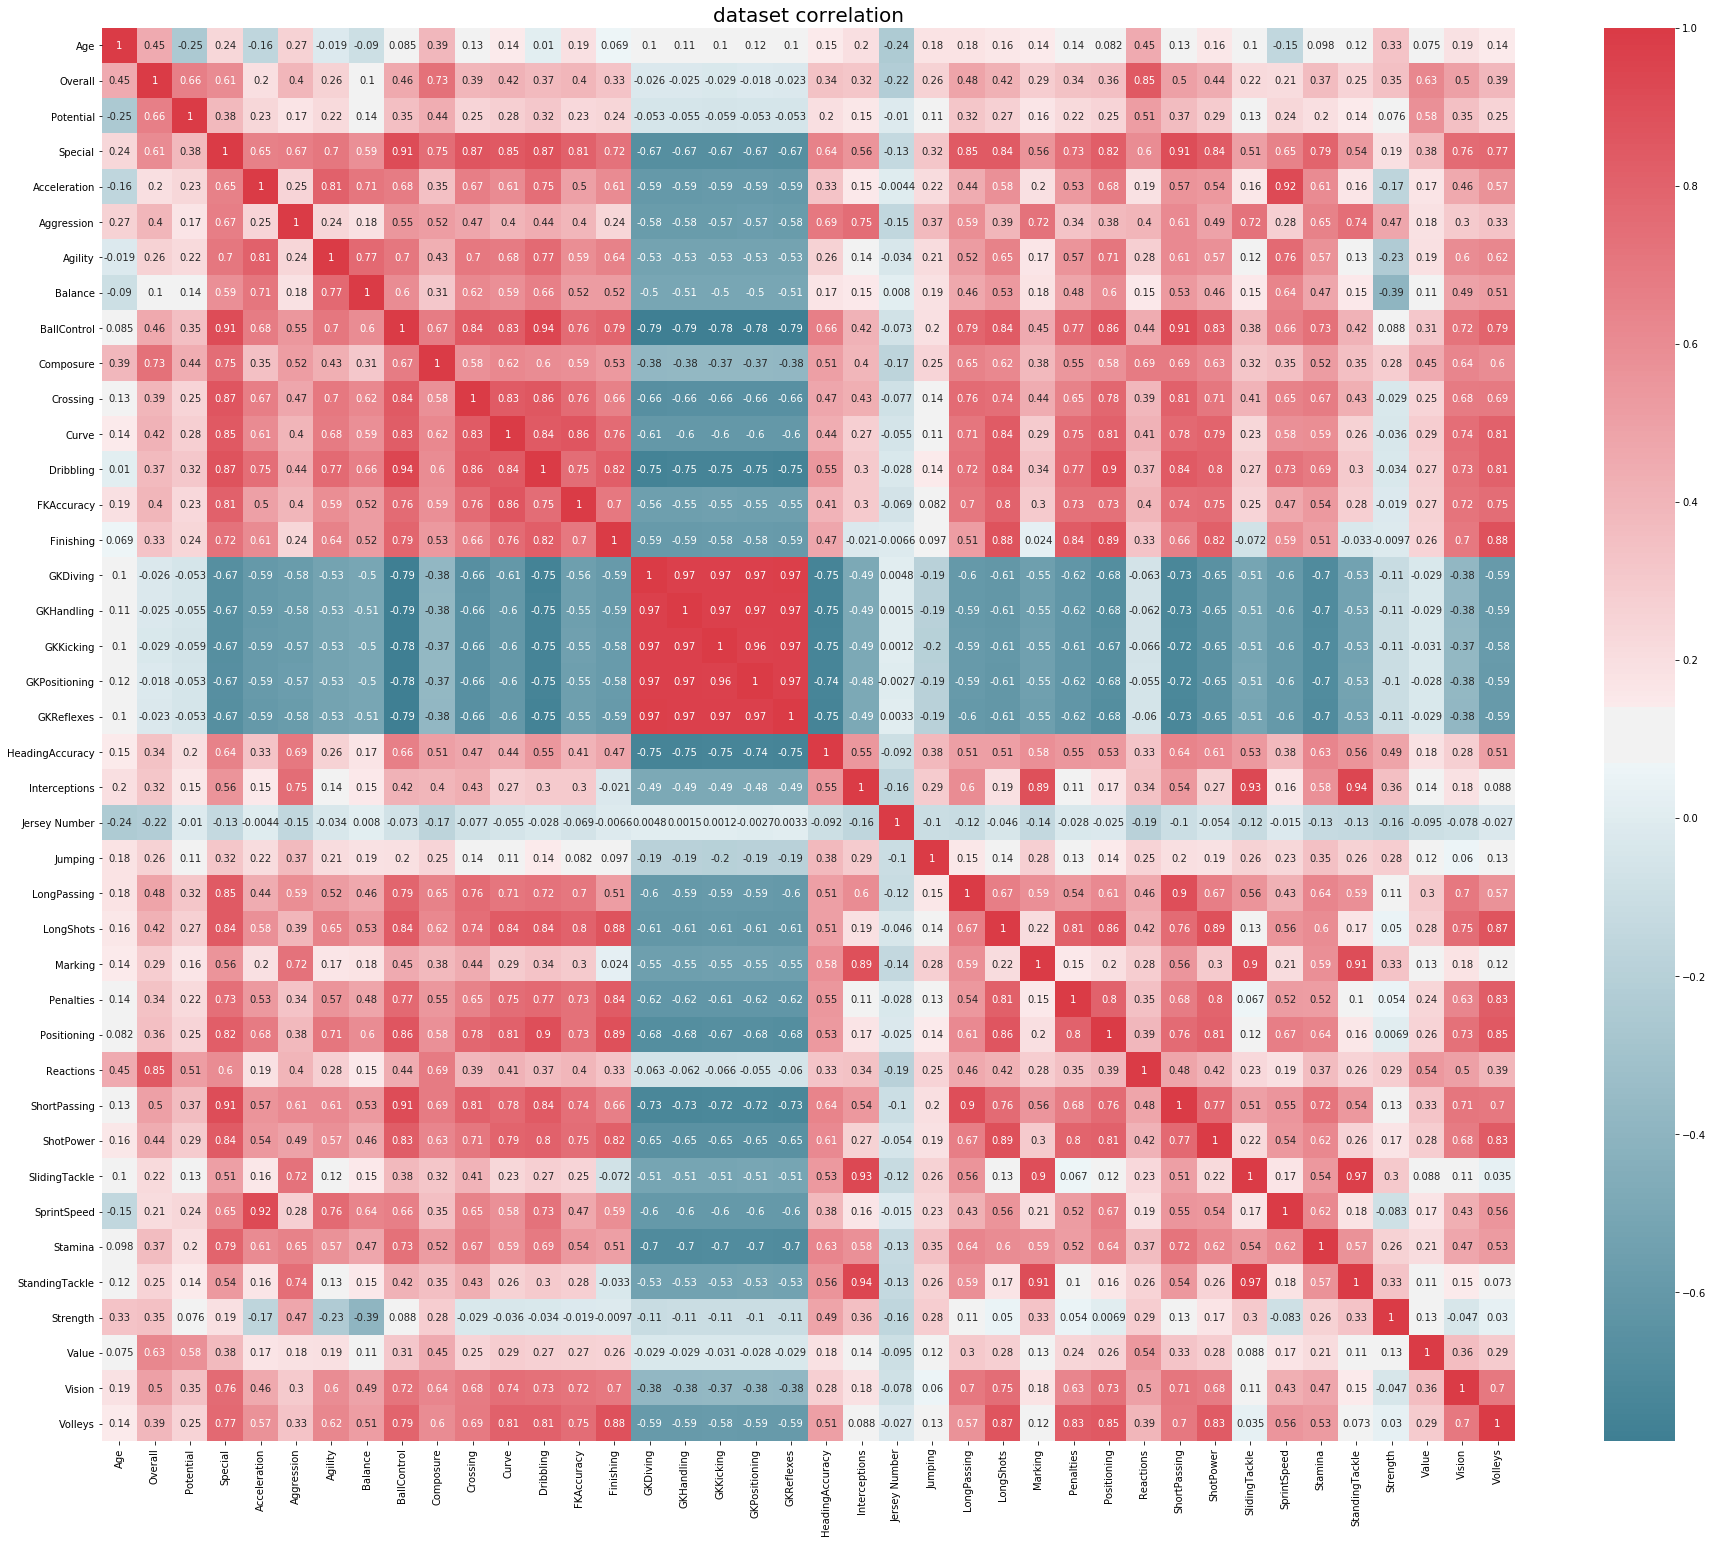

In [30]:
# Display correlation after removing correlated features
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(32, 26))
corr = df[numeric_features].corr()
mp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot = True)
mp.set_title(label='dataset correlation', fontsize=20)

#### checking for numerical features outliers

In [31]:
for c in numeric_features:
    print(c)
    print(df[c].value_counts(bins=10, sort=False))

Age
(15.97, 18.9]    1063
(18.9, 21.8]     3687
(21.8, 24.7]     4030
(24.7, 27.6]     3868
(27.6, 30.5]     2977
(30.5, 33.4]     1689
(33.4, 36.3]      727
(36.3, 39.2]      144
(39.2, 42.1]       19
(42.1, 45.0]        3
Name: Age, dtype: int64
Overall
(45.951, 50.8]     192
(50.8, 55.6]       998
(55.6, 60.4]      2363
(60.4, 65.2]      4727
(65.2, 70.0]      5178
(70.0, 74.8]      2681
(74.8, 79.6]      1513
(79.6, 84.4]       445
(84.4, 89.2]        96
(89.2, 94.0]        14
Name: Overall, dtype: int64
Potential
(47.952000000000005, 52.7]      16
(52.7, 57.4]                   102
(57.4, 62.1]                  1007
(62.1, 66.8]                  2973
(66.8, 71.5]                  5645
(71.5, 76.2]                  4908
(76.2, 80.9]                  2185
(80.9, 85.6]                  1097
(85.6, 90.3]                   245
(90.3, 95.0]                    29
Name: Potential, dtype: int64
Special
(729.384, 892.5]     320
(892.5, 1054.0]      659
(1054.0, 1215.5]     975
(1215.5, 1377

Let's check missing values for these numerical features.

In [32]:
print(df[numeric_features].isna().sum())

Age                 0
Overall             0
Potential           0
Special             0
Acceleration       48
Aggression         48
Agility            48
Balance            48
BallControl        48
Composure          48
Crossing           48
Curve              48
Dribbling          48
FKAccuracy         48
Finishing          48
GKDiving           48
GKHandling         48
GKKicking          48
GKPositioning      48
GKReflexes         48
HeadingAccuracy    48
Interceptions      48
Jersey Number      60
Jumping            48
LongPassing        48
LongShots          48
Marking            48
Penalties          48
Positioning        48
Reactions          48
ShortPassing       48
ShotPower          48
SlidingTackle      48
SprintSpeed        48
Stamina            48
StandingTackle     48
Strength           48
Value               0
Vision             48
Volleys            48
dtype: int64


As a quick fix, we will apply mean imputation. This will replace the missing values with the mean value of the corresponding column.

__Note__: The statistically correct way to perform mean/mode imputation before training an ML model is to compute the column-wise means on the training data only, and then use these values to impute missing data in both the train and test sets. So, we'll need to split our dataset first. Same goes for any other transformations we would like to apply to these numerical features, such as scaling. 

#### Cleaning categorical features 

Let's also examine the categorical features.

In [33]:
for c in text_categorical_features:
    print(c)
    print(df[c].unique()) #value_counts())

Nationality
['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' 'Switzerland' 'Norway' 'Czech Republic' 'Scotland'
 'Ghana' 'Central African Rep.' 'DR Congo' 'Ivory Coast' 'Russia'
 'Ukraine' 'Iceland' 'Mexico' 'Jamaica' 'Albania' 'Venezuela' 'Japan'
 'Turkey' 'Ecuador' 'Paraguay' 'Mali' 'Nigeria' 'Cameroon'
 'Dominican Republic' 'Israel' 'Kenya' 'Hungary' 'Republic of Ireland'
 'Romania' 'United States' 'Cape Verde' 'Australia' 'Peru' 'Togo' 'Syria'
 'Zimbabwe' 'Angola' 'Burkina Faso' 'Iran' 'Estonia' 'Tunisia'
 'Equatorial Guinea' 'New Zealand' 'FYR Macedonia' 'United Arab Emirates'
 'China PR' 'Guinea Bissau' 'Bulgaria' 'Kosovo' 'South Africa'
 'Madagascar' 'Georgia' 'T

In [34]:
df[text_categorical_features] = df[text_categorical_features].astype('str')

In [35]:
df[numeric_categorical_features] = df[numeric_categorical_features].astype('str')

In [36]:
df[numeric_features] = df[numeric_features].astype('float32')

In [37]:
df[label_feature] = df[label_feature].astype('float32')

In [38]:
df['Wage'].head(2)

0    565000.0
1    405000.0
Name: Wage, dtype: float32

__Note on boolean type__: Most categories are strings, except the __nan__s, and the booleans __False__ and __True__. The booleans will raise errors when trying to encode the categoricals with sklearn encoders, none of which accept boolean types. If using pandas get_dummies to one-hot encode the categoricals, there's no need to convert the booleans. However, get_dummies is trickier to use with sklearn's Pipeline and GridSearch. 

One way to deal with the booleans is to convert them to strings, by using a mask and a map changing only the booleans.

The current data set doesn't have booleans, but here is a sample code

mask = df.applymap(type) != bool

do = {True: 'TRUE', False: 'FALSE'}

df_masked = df.where(mask, df.replace(do))

Another way to handle the booleans is to convert them to strings by changing the type of all categoricals to 'str'. This will also affect the nans, basically performing imputation of the nans with a 'nans' placeholder value! 

Applying the type conversion to both categoricals and text features, takes care of the nans in the text fields as well. In case other imputations are planned for the categoricals and/or test fields, notice that the masking shown above leaves the nans unchanged.

df[boolean_features] = df[boolean_features].astype('str')

Converting categoricals into useful numerical features, will also have to wait until after the train/test split.

#### Cleaning text features 

Also a good idea to look at the text fields. Text cleaning can be performed here, before train/test split, with less code.

We dont have text in this dataset but we will use date_features to show the functions.

In [39]:
text_features = date_features
df[date_features] = df[date_features].astype('str')

We re-use the helper functions from the 'Text processing' notebook above.

In [40]:
# Prepare cleaning functions
import re, string
import nltk
from nltk.stem import SnowballStemmer

stop_words = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "aren't", 
              "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", 
              "can't", "cannot", "could", "couldn't", "did", "didn't", "do", "does", "doesn't", "doing", "don't", 
              "down", "during", "each", "few", "for", "from", "further", "had", "hadn't", "has", "hasn't", "have", 
              "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", 
              "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "isn't", 
              "it", "it's", "its", "itself", "let's", "me", "more", "most", "mustn't", "my", "myself", "no", "nor", 
              "not", "of", "off", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", 
              "over", "own", "same", "shan't", "she", "she'd", "she'll", "she's", "should", "shouldn't", "so", 
              "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", 
              "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", 
              "through", "to", "too", "under", "until", "up", "very", "was", "wasn't", "we", "we'd", "we'll", 
              "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's", "which", 
              "while", "who", "who's", "whom", "why", "why's", "with", "won't", "would", "wouldn't", "you", "you'd", 
              "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]

stemmer = SnowballStemmer('english')

def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()
    
    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove extra white space
    text = re.sub('\s+', ' ', text)
    
    return text

def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)
    
    return text

def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)

# Clean the text features
for c in text_features:
    print('Text cleaning: ', c)
    df[c] = [cleanSentence(item, stop_words, stemmer) for item in df[c].values]

Text cleaning:  Joined


The cleaned text features are ready to be vectorized after the train/test split. In our case we wont use this because the only useful text field is date.

## 4. <a name="4">Training and test datasets</a>
(<a href="#0">Go to top</a>)

We split our dataset into training (90%) and test (10%) subsets using sklearn's [__train_test_split()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [41]:
df = df[pd.notnull(df[label_feature])]

In [78]:
#df[label] = df[label] / 1000000

In [79]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df[all_features], test_size=0.2, shuffle=True, random_state=23)
val_data, test_data = train_test_split(test_data, test_size=0.2, shuffle=True, random_state=23)


## 5. <a name="5">Data processing with Pipeline and ColumnTransformer</a>
(<a href="#0">Go to top</a>)

Let's build a more complex pipeline today. We first build separate pipelines to handle the numerical, categorical, and text features, and then combine them into a composite pipeline along with an estimator, a [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) here.

   * For the numerical features pipeline, the __numerical_processor__ below, we impute missing values with the mean using sklearn's SimpleImputer, followed by a MinMaxScaler (don't have to scale features when using Decision Trees, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.
   
   
   * In the categoricals pipeline, the __categorical_processor__ below, we impute with a placeholder value (no effect here as we already encoded the 'nan's), and encode with sklearn's OneHotEncoder. If computing memory is an issue, it is a good idea to check categoricals' unique values, to get an estimate of many dummy features will be created by one-hot encoding. Note the __handle_unknown__ parameter that tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation/and or test set that was not present in the initial training set.
   
   
The selective preparations of the dataset features are then put together into a collective ColumnTransformer, to be finally used in a Pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.

In [80]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
#    ('num_scaler', MinMaxScaler()) # Shown in case is needed, not a must with Decision Trees
                                ])
                  
# Preprocess the categorical features
categorical_processor = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='nan')), # Shown in case is needed, no effect here as we already imputed with 'nan' strings
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')) # handle_unknown tells it to ignore (rather than throw an error for) any value that was not present in the initial training set.
                                ])

# Preprocess 1st text feature
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(binary=True, max_features=50))
                                ])

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numeric_features),
    ('categorical_pre', categorical_processor, (text_categorical_features + numeric_categorical_features)),
#    ('text_pre_0', text_processor_0, text_features[0]),
                                    ]) 

### PIPELINE ###
################

# Pipeline desired all data transformers, along with an estimator at the end
# Later you can set/reach the parameters using the names issued - for hyperparameter tuning, for example
pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('dt', RandomForestRegressor(max_depth=10, random_state=0))
                    ])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'Overall',
                                                   'Potential', 'Special',
                                                   'Acceleration', 'Aggression',
                                                   'Agility', 'Balance',
                                                   'BallControl', 'Composure',
                                                   'Crossing', 'Curve',
                                                   'Dribbling', 'FKAccuracy',
                                                   'Finishing', 'GKDiving',
                                                   'GKHandling', 'GKKicking',
                                                   'GKPosit...
                                                   'Positioning', 'Reactions', ...]),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='nan',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Nationality', 'Body Type',
                                                   'Club', 'Position',
                                                   'Preferred Foot',
                                                   'Work Rate',
                                                   'International Reputation',
                                                   'Skill Moves',
                                                   'Weak Foot'])])),
                ('dt', RandomForestRegressor(max_depth=10, random_state=0))])

## 6. <a name="6">Train and tune a classifier</a>
(<a href="#0">Go to top</a>)

Let's first train and test the above composite pipeline on the train and the test sets.  

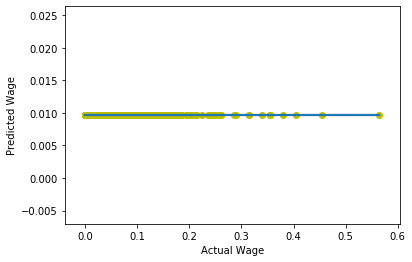

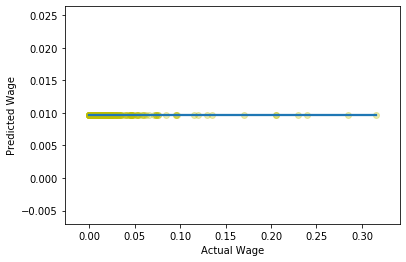

In [81]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get train data to train the pipeline
X_train = train_data[numeric_features + text_categorical_features + numeric_categorical_features]
y_train = train_data[label]

# Fit the Pipeline to training data
pipeline.fit(X_train, y_train)

# Use the fitted pipeline to make predictions on the train dataset
train_predictions = pipeline.predict(X_train)

#this is for binary classification
#print(confusion_matrix(y_train, train_predictions))
#print(classification_report(y_train, train_predictions))
#print("Accuracy (training):", accuracy_score(y_train, train_predictions))


# Get test data to test the pipeline
X_test = test_data[numeric_features + text_categorical_features + numeric_categorical_features]
y_test = test_data[label]

# Use the fitted pipeline to make predictions on the test dataset
test_predictions = pipeline.predict(X_test)
#print(confusion_matrix(y_test, test_predictions))
#print(classification_report(y_test, test_predictions))
#print("Accuracy (test):", accuracy_score(y_test, test_predictions))

sb.regplot(y_train, train_predictions, scatter_kws={'alpha':1, 'color':'y'})
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.show()

sb.regplot(y_test, test_predictions, scatter_kws={'alpha':0.3, 'color':'y'})
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.show()


## 8. <a name="28">Improvement Ideas</a>
(<a href="#0">Go to top</a>)

* Utilize the text fields to improve our performance (count Bag of Words vectorization, Tfidf vectorization)
* Try target enconding for categorical variables (check slides)
* Feature selection: Not all features may be important, we can achieve higher performance by selecting a subset of our features.
* Try ensemble models such as Random Forests, along with RandomizedSearchCV to speed up the hyperparameter tuning task. (check slides)
